In [1]:
import sys

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile
import seaborn as sns
sns.set(style="darkgrid")

import google.protobuf.json_format as json_format

import warnings
warnings.simplefilter('ignore')

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from banditpylib.arms import BernoulliArm
from banditpylib.bandits import OrdinaryBandit
from banditpylib.protocols import SinglePlayerProtocol, parse_trials_data
from banditpylib.learners.ordinary_learner import UCB, EpsGreedy, ThompsonSampling

In [3]:
horizon = 2000
means = np.array([0.3, 0.5, 0.7])
arms = [BernoulliArm(mean) for mean in means]
bandit = OrdinaryBandit(arms=arms)
learners = [EpsGreedy(arm_num=len(arms), name='Epsilon Greedy'), 
            UCB(arm_num=len(arms), name='UCB'),
            ThompsonSampling(arm_num=len(arms), name='Thompson Sampling')]
# intermediate regrets to record for each trial of a game
intermediate_regrets = list(range(0, horizon+1, 50))
temp_file = tempfile.NamedTemporaryFile()

In [4]:
# simulator
game = SinglePlayerProtocol(bandit, learners, intermediate_regrets=intermediate_regrets, horizon=horizon)
# start playing the game
# add `debug=True` for debugging purpose
game.play(trials=200, output_filename=temp_file.name)

INFO:absl:start Epsilon Greedy's play with ordinary_bandit
INFO:absl:Epsilon Greedy's play with ordinary_bandit runs 6.64 seconds.
INFO:absl:start UCB's play with ordinary_bandit
INFO:absl:UCB's play with ordinary_bandit runs 8.67 seconds.
INFO:absl:start Thompson Sampling's play with ordinary_bandit
INFO:absl:Thompson Sampling's play with ordinary_bandit runs 8.57 seconds.


In [5]:
with open(temp_file.name, 'rb') as f:
  data = []
  trials_data = parse_trials_data(f.read())
  for one_trial_data in trials_data:
    for data_item in one_trial_data.data_items:
        data.append(json_format.MessageToDict(data_item, 
                                              including_default_value_fields=True, 
                                              preserving_proto_field_name=True))
  data_df = pd.DataFrame.from_dict(data)

In [6]:
data_df.head()

,bandit,learner,rounds,total_actions,regret
0,ordinary_bandit,Epsilon Greedy,0,0,0.0
1,ordinary_bandit,Epsilon Greedy,50,50,10.0
2,ordinary_bandit,Epsilon Greedy,100,100,24.0
3,ordinary_bandit,Epsilon Greedy,150,150,35.0
4,ordinary_bandit,Epsilon Greedy,200,200,44.0


<AxesSubplot:xlabel='total_actions', ylabel='regret'>

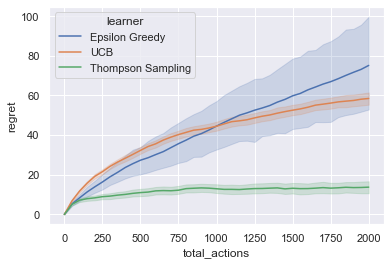

In [7]:
sns.lineplot(x='total_actions', y='regret', hue='learner', data=data_df)